In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
pd.options.mode.chained_assignment = None 

In [2]:
df = pd.read_csv("shopify.csv")

In [3]:
df.head()

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at
0,1,53,746,224,2,cash,2017-03-13 12:36:56
1,2,92,925,90,1,cash,2017-03-03 17:38:52
2,3,44,861,144,1,cash,2017-03-14 4:23:56
3,4,18,935,156,1,credit_card,2017-03-26 12:43:37
4,5,18,883,156,1,credit_card,2017-03-01 4:35:11


### (a) Think about what could be going wrong with our calculation. Think about a better way to evaluate this data.

In [4]:
df.order_amount.describe()

count      5000.000000
mean       3145.128000
std       41282.539349
min          90.000000
25%         163.000000
50%         284.000000
75%         390.000000
max      704000.000000
Name: order_amount, dtype: float64

From the summary statistics, we can see that AOV is calculated by using the mean of order_amount. We also see that we have outliers because the third quartile is 390 while the maximum is 704000. Therefore, I decided to further investigate the overall distribution of order amounts. 

<AxesSubplot:>

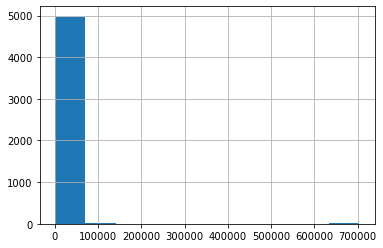

In [5]:
df.order_amount.hist() 

<AxesSubplot:>

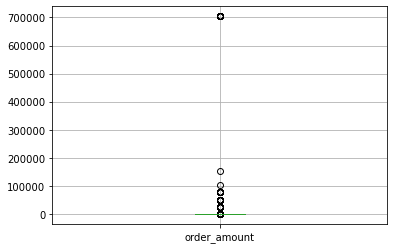

In [6]:
df.boxplot(column='order_amount')

From both the histogram and the boxplot, we can see that we have many outliers and the data is heavily right-skewed. Let's further explore why we are getting such large outliers because they are causing AOV to be high.

In [7]:
Q1 = df.order_amount.quantile(q=0.25)
Q2 = df.order_amount.quantile(q=0.5)
Q3 = df.order_amount.quantile(q=0.75)
IQR = Q3 - Q1

In [8]:
outliers = df[df.order_amount>=Q3+1.5*IQR]
outliers.sort_values(by='order_amount',ascending=False).head(20)

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at
15,16,42,607,704000,2000,credit_card,2017-03-07 4:00:00
520,521,42,607,704000,2000,credit_card,2017-03-02 4:00:00
1562,1563,42,607,704000,2000,credit_card,2017-03-19 4:00:00
1362,1363,42,607,704000,2000,credit_card,2017-03-15 4:00:00
1602,1603,42,607,704000,2000,credit_card,2017-03-17 4:00:00
4056,4057,42,607,704000,2000,credit_card,2017-03-28 4:00:00
3332,3333,42,607,704000,2000,credit_card,2017-03-24 4:00:00
1104,1105,42,607,704000,2000,credit_card,2017-03-24 4:00:00
2153,2154,42,607,704000,2000,credit_card,2017-03-12 4:00:00
2297,2298,42,607,704000,2000,credit_card,2017-03-07 4:00:00


In [9]:
bulk=outliers.groupby(['user_id','shop_id','total_items']).size().reset_index(name='order_count')
bulk.sort_values(by='total_items',ascending=False).head()

,user_id,shop_id,total_items,order_count
0,607,42,2000,17
12,733,54,8,1
2,706,67,6,1
77,878,78,6,1
122,993,13,6,1


From the two tables above, we can see that the maximum order amount of $704000 is coming from user #607 making bulk orders of 2000 (they have done it 17 times to be exact). Fortunately, no other user is making bulk orders from the same shop. Let's further investigate where other outliers are coming from by calculating the price per shoes for each shop. 

In [10]:
outliers['price'] = outliers.order_amount/outliers.total_items
prices=outliers.groupby(['shop_id','price']).size().reset_index(name='order_count')
prices.sort_values(by='price',ascending=False).head()

,shop_id,price,order_count
29,78,25725.0,46
15,42,352.0,23
3,12,201.0,2
36,89,196.0,3
41,99,195.0,2


The table above shows that shop ID 78 sells a shoe model that is \\$25,725. It is likely that the shop sells a high-end shoe model. In conclusion,  the high AOV of \\$3,145.13 comes from naively calculating the mean of the order_amount without examining outliers such as bulk orders and stores that may sell more expensive shoe brands.

### (b) What metric would you report for this dataset?

1. I would report the median because it is less sensitive to outliers and our dataset is skewed.
2. If I want to report the mean, I can take advantage of the Central Limit Theorem and find the mean of the sampling distribution of the sample means.

### (c) What is its value?

In [11]:
#median
df.order_amount.median()

284.0

<AxesSubplot:>

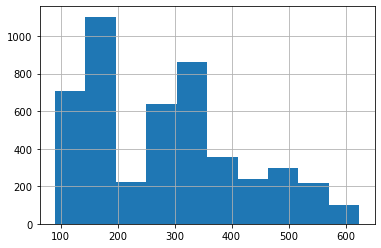

In [12]:
df_clean = df[(df.order_amount < Q2 + IQR * 1.5) & (df.order_amount > Q2 - IQR * 1.5)]
df_clean['order_amount'].hist() 

<AxesSubplot:>

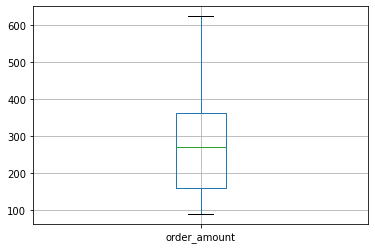

In [13]:
df_clean.boxplot(column='order_amount')

In [14]:
#median of cleaned data
df_clean['order_amount'].median()

272.0

In [25]:
#sampling distribution of sample means
np.random.seed(1)
size= 500
sample_means = np.repeat(0,10000)

for i in range(10000):
    sample = df_clean['order_amount'].sample(n=size)
    sample_means[i] = sample.mean()


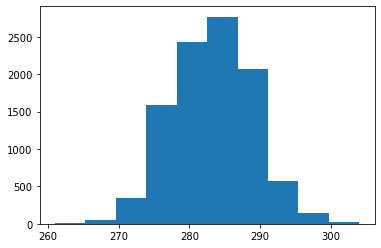

In [26]:
plt.hist(sample_means)
plt.show()

In [27]:
sample_means.mean()

283.2863